In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
import pandas as pd 
import gensim
import numpy as np
import pandas as pd
import os
import re
import csv
import codecs
import sys
import pickle
from csv import DictReader

# from utils.dataset import DataSet
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Embedding,LSTM, Dense
from keras.models import Sequential
import nltk

nltk.download('punkt')
nltk.download('wordnet')



from gensim.scripts.glove2word2vec import glove2word2vec
from gensim.models import KeyedVectors
from sklearn.model_selection import train_test_split
from numpy import zeros

from keras import callbacks
from keras import optimizers
from keras.models import Sequential, Model
from keras.layers import Input, Dense, LSTM, Embedding, Dropout, BatchNormalization, Activation, Bidirectional,Flatten
from keras.layers.merge import concatenate
from keras.layers.normalization import BatchNormalization
from keras.preprocessing.text import text_to_word_sequence, Tokenizer
from keras.preprocessing.sequence import pad_sequences

import matplotlib as mpl
%matplotlib inline
from matplotlib import pyplot as plt
from keras.utils import plot_model 
from IPython.display import Image
# import pydot
from sklearn.preprocessing import LabelEncoder
from keras.utils import np_utils
import tensorflow as tf

from numpy import asarray
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer

from string import punctuation

from keras import backend as K
from keras.engine.topology import Layer
#from keras import initializations
from keras import initializers, regularizers, constraints

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


## SCORER.py

In [ ]:
#Adapted from https://github.com/FakeNewsChallenge/fnc-1/blob/master/scorer.py
#Original credit - @bgalbraith

LABELS = ['agree', 'disagree', 'discuss', 'unrelated']
LABELS_RELATED = ['unrelated','related']
RELATED = LABELS[0:3]

def score_submission(gold_labels, test_labels):
    score = 0.0
    cm = [[0, 0, 0, 0],
          [0, 0, 0, 0],
          [0, 0, 0, 0],
          [0, 0, 0, 0]]

    for i, (g, t) in enumerate(zip(gold_labels, test_labels)):
        g_stance, t_stance = g, t
        if g_stance == t_stance:
            score += 0.25
            if g_stance != 'unrelated':
                score += 0.50
        if g_stance in RELATED and t_stance in RELATED:
            score += 0.25

        cm[LABELS.index(g_stance)][LABELS.index(t_stance)] += 1

    return score, cm


def print_confusion_matrix(cm):
    lines = []
    header = "|{:^11}|{:^11}|{:^11}|{:^11}|{:^11}|".format('', *LABELS)
    line_len = len(header)
    lines.append("-"*line_len)
    lines.append(header)
    lines.append("-"*line_len)

    hit = 0
    total = 0
    for i, row in enumerate(cm):
        hit += row[i]
        total += sum(row)
        lines.append("|{:^11}|{:^11}|{:^11}|{:^11}|{:^11}|".format(LABELS[i],
                                                                   *row))
        lines.append("-"*line_len)
    print('\n'.join(lines))


def report_score(actual,predicted):
    score,cm = score_submission(actual,predicted)
    print("Score",score)
    best_score, _ = score_submission(actual,actual)
    # print("best_Score",best_score)

    print_confusion_matrix(cm)
    print("Score: " +str(score) + " out of " + str(best_score) + "\t("+str(score*100/best_score) + "%)")
    return score*100/best_score


if __name__ == "__main__":
    actual = [0,0,0,0,1,1,0,3,3]
    predicted = [0,0,0,0,1,1,2,3,3]

    report_score([LABELS[e] for e in actual],[LABELS[e] for e in predicted])

Score 6.75
-------------------------------------------------------------
|           |   agree   | disagree  |  discuss  | unrelated |
-------------------------------------------------------------
|   agree   |     4     |     0     |     1     |     0     |
-------------------------------------------------------------
| disagree  |     0     |     2     |     0     |     0     |
-------------------------------------------------------------
|  discuss  |     0     |     0     |     0     |     0     |
-------------------------------------------------------------
| unrelated |     0     |     0     |     0     |     2     |
-------------------------------------------------------------
Score: 6.75 out of 7.5	(90.0%)


## EMBEDDING DIR

In [ ]:
# Specify the folder locations
W2V_DIR = './data/GoogleNews-vectors-negative300.bin' # W2v
GloVe_DIR = './data/glove.6B.300d.txt' #Glove
FastTxt_DIR = './data/wiki-news-300d-1M.vec' #fasttext



## CONFIG

In [ ]:

#the data directory
MAX_SENT_LEN = 150      #75(0.68), 150, 300 700(90% but too time comsuming)
MAX_VOCAB_SIZE = 40000 #vocabulary
LSTM_DIM = 256#len(embd[0])
EMBEDDING_DIM = 300 #50 for GloVe 300 for w2v
BATCH_SIZE = 128
N_EPOCHS = 40 

## DATASET

In [ ]:
class DataSet():
    def __init__(self, name="train", path="./data"):
        self.path = path

        print("Reading dataset")
        bodies = name+"_bodies.csv"
        stances = name+"_stances.csv"

        self.stances = self.read(stances)
        articles = self.read(bodies)
        self.articles = dict()

        #make the body ID an integer value
        for s in self.stances:
            s['Body ID'] = int(s['Body ID'])

        #copy all bodies into a dictionary
        for article in articles:
            self.articles[int(article['Body ID'])] = article['articleBody']

        print("Total stances: " + str(len(self.stances)))
        print("Total bodies: " + str(len(self.articles)))



    def read(self,filename):
        rows = []
        with open(self.path + "/" + filename, "r", encoding='utf-8') as table:
            r = DictReader(table)

            for line in r:
                rows.append(line)
        return rows


## GEN FEATURES

In [ ]:
def generate_features(stances,dataset):
    h, b, y = [],[],[]
    LABELS = ['agree', 'disagree', 'discuss', 'unrelated']
    for stance in stances:

        # print(stance['Stance'])
        y.append(LABELS.index(stance['Stance']))
        h.append(stance['Headline'])
        b.append(dataset.articles[stance['Body ID']])
   

    return(h,b,y)


## CALLING DATASET

In [ ]:
d=DataSet()
h,b,y= generate_features(d.stances,d)

combined_list = [list(x) for x in zip(h, b,y)]

combine_df_train=pd.DataFrame(combined_list,columns = ["Headline","articleBody","Stances"])
combine_df_train.to_csv("./data/combined_list_1.csv")



Reading dataset
Total stances: 49972
Total bodies: 1683


In [ ]:
combine_df_train.head()

,Headline,articleBody,Stances
0,Police find mass graves with at least '15 bodi...,Danny Boyle is directing the untitled film\n\n...,3
1,Hundreds of Palestinians flee floods in Gaza a...,Hundreds of Palestinians were evacuated from t...,0
2,"Christian Bale passes on role of Steve Jobs, a...",30-year-old Moscow resident was hospitalized w...,3
3,HBO and Apple in Talks for $15/Month Apple TV ...,(Reuters) - A Canadian soldier was shot at the...,3
4,Spider burrowed through tourist's stomach and ...,"Fear not arachnophobes, the story of Bunbury's...",1


In [ ]:
competition_dataset = DataSet("competition_test")
h_test,b_test,y_test= generate_features(competition_dataset.stances,competition_dataset)

combined_list_test = [list(x_test) for x_test in zip(h_test, b_test, y_test)]

combine_df_test=pd.DataFrame(combined_list_test,columns = ["Headline","articleBody","Stances"])
combine_df_test.to_csv("./data/combined_list_test.csv")



Reading dataset
Total stances: 25413
Total bodies: 904


In [ ]:
combine_df_test.head()

,Headline,articleBody,Stances
0,Ferguson riots: Pregnant woman loses eye after...,A RESPECTED senior French police officer inves...,3
1,Crazy Conservatives Are Sure a Gitmo Detainee ...,Dave Morin's social networking company Path is...,3
2,A Russian Guy Says His Justin Bieber Ringtone ...,A bereaved Afghan mother took revenge on the T...,3
3,"Zombie Cat: Buried Kitty Believed Dead, Meows ...",Hewlett-Packard is officially splitting in two...,3
4,Argentina's President Adopts Boy to End Werewo...,An airline passenger headed to Dallas was remo...,3


## PREPROCESS

In [ ]:
import nltk
nltk.download('stopwords')
stop_words = set(stopwords.words('english')) 
def text_cleaner(text):
    newString = text.lower()
    newString = re.sub('<br\s?\/>|<br>', "", newString)
    newString = newString.replace('\n','')
    newString = re.sub(r'\([^)]*\)', '', newString)
    newString = re.sub('"','', newString)

    newString = re.sub(r"'s\b","",newString)
    newString = re.sub("[^a-zA-Z]", " ", newString) 

    tokens = [w for w in newString.split() if not w in stop_words]
    return ( " ".join(tokens)).strip()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


TF-IDF

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer


In [ ]:
train_head = [text_cleaner(head) for head in combine_df_train['Headline']]
train_body = [text_cleaner(body) for body in combine_df_train['articleBody']]
test_head = [text_cleaner(head) for head in combine_df_test['Headline']]
test_body = [text_cleaner(body) for body in combine_df_test['articleBody']]

In [ ]:
vectorizer = TfidfVectorizer(max_features = 150)
X_train_head_tfidf = vectorizer.fit_transform(train_head).toarray()

In [ ]:
X_train_body_tfidf = vectorizer.fit_transform(train_body).toarray()


In [ ]:
X_train_body_tfidf.shape

(49972, 150)

In [ ]:
X_test_head_tfidf= vectorizer.transform(test_head).toarray()


In [ ]:
X_test_body_tfidf = vectorizer.transform(test_body).toarray()

In [ ]:
import tensorflow as tf
tf.compat.v1.disable_eager_execution()

In [ ]:
# Pre-processing involves removal of puctuations and converting text to lower case
word_seq_head_train = [text_to_word_sequence(text_cleaner(head)) for head in combine_df_train['Headline']]
word_seq_bodies_train = [text_to_word_sequence(text_cleaner(body)) for body in combine_df_train['articleBody']]
word_seq_head_test = [text_to_word_sequence(text_cleaner(head)) for head in combine_df_test['Headline']]
word_seq_bodies_test = [text_to_word_sequence(text_cleaner(body)) for body in combine_df_test['articleBody']]

In [ ]:
word_seq = []
for i in range(len(word_seq_head_train)):
    word_seq.append(word_seq_head_train[i])
for i in range(len(word_seq_bodies_train)):
    word_seq.append(word_seq_bodies_train[i])

# word_seq_test_1 = []
for i in range(len(word_seq_head_test)):
    word_seq.append(word_seq_head_test[i])
for i in range(len(word_seq_bodies_test)):
    word_seq.append(word_seq_bodies_test[i])

In [ ]:
filter_list = '!"\'#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n'

tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE, filters=filter_list)
tokenizer.fit_on_texts([seq for seq in word_seq])
#because it only includes unique words(tokens)

print("Number of words in vocabulary:", len(tokenizer.word_index))

Number of words in vocabulary: 29976


## TEXT with two LSTM FOR head and body

In [ ]:
# Shorten the sentence to a fixed length
# Convert the sequence of words to sequnce of indices
X_train_head = tokenizer.texts_to_sequences([' '.join(seq[:MAX_SENT_LEN]) for seq in word_seq_head_train])
X_train_head = pad_sequences(X_train_head, maxlen=MAX_SENT_LEN, padding='post', truncating='post')

X_train_body = tokenizer.texts_to_sequences([' '.join(seq[:MAX_SENT_LEN]) for seq in word_seq_bodies_train])
X_train_body = pad_sequences(X_train_body, maxlen=MAX_SENT_LEN, padding='post', truncating='post')

y_train_1 = combine_df_train['Stances']


X_test_head = tokenizer.texts_to_sequences([' '.join(seq[:MAX_SENT_LEN]) for seq in word_seq_head_test])
X_test_head = pad_sequences(X_test_head, maxlen=MAX_SENT_LEN, padding='post', truncating='post')

X_test_body = tokenizer.texts_to_sequences([' '.join(seq[:MAX_SENT_LEN]) for seq in word_seq_bodies_test])
X_test_body = pad_sequences(X_test_body, maxlen=MAX_SENT_LEN, padding='post', truncating='post')

y_test_1 = combine_df_test['Stances']


y_train = np_utils.to_categorical(y_train_1)
y_test = np_utils.to_categorical(y_test_1)



W2v

In [ ]:
def embed_matrix(model,word_index,EMBEDDING_DIM):
  embeddings_matrix = np.random.uniform(-0.05, 0.05, size=(len(word_index)+1, EMBEDDING_DIM)) # +1 is because the matrix indices start with 0
  for word, i in word_index.items(): # i=0 is the embedding for the zero padding
      try:
          embeddings_vector = model.wv.get_vector(word)
      except KeyError:
          embeddings_vector = None
          #none: if words in sentence don't have pre-trained corresponding embedding, then error occurs

      if embeddings_vector is not None:
          embeddings_matrix[i] = embeddings_vector
          #if pre-trained word embedding exists，then let embeddings_matrix[i] is this embedding
          #Wi:the ith row of embeddings_matrix

  return embeddings_matrix

In [ ]:
# Load the word2vec embeddings 
embeddings_w2v = gensim.models.KeyedVectors.load_word2vec_format(W2V_DIR, binary=True)

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:254: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


In [ ]:
embeddings_matrix_w2v= embed_matrix(embeddings_w2v,tokenizer.word_index,EMBEDDING_DIM)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  """


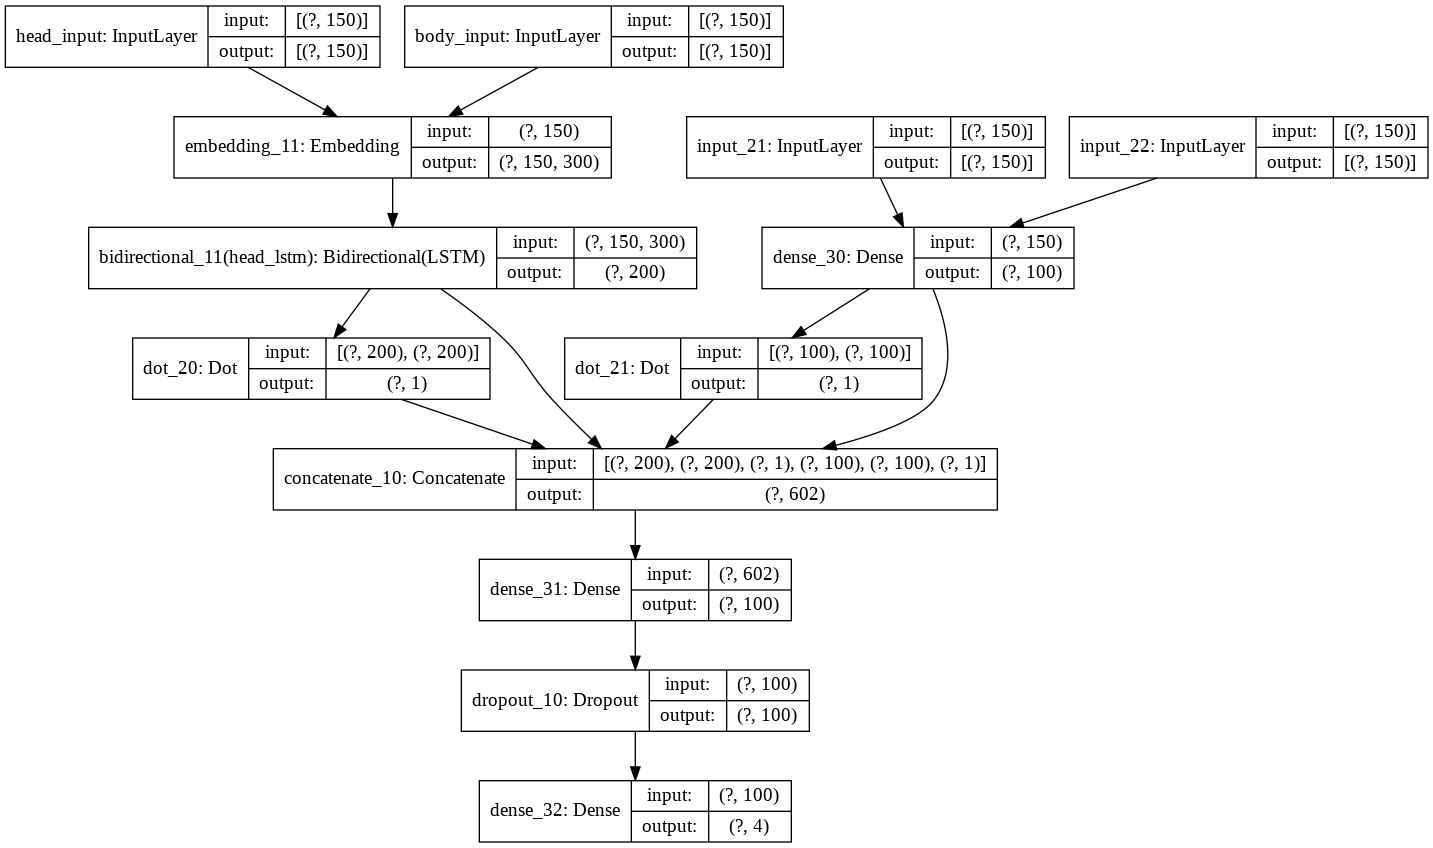

In [ ]:
from keras.layers import concatenate,dot
from keras. optimizers import Adam
from IPython.display import SVG

head_input = Input(shape=(MAX_SENT_LEN,), dtype='int32', name='head_input')
body_input = Input(shape=(MAX_SENT_LEN,), dtype='int32', name='body_input')

shared_embed = Embedding(len(tokenizer.word_index) + 1,EMBEDDING_DIM,weights=[embeddings_matrix_w2v],trainable=False)
head_embed = shared_embed(head_input)
body_embed = shared_embed(body_input)

shared_lstm = Bidirectional(LSTM(100,dropout=0.2, recurrent_dropout=0.2, name='head_lstm'))
head_lstm = shared_lstm(head_embed)
body_lstm = shared_lstm(body_embed)

dot_layer = dot([head_lstm,body_lstm],axes = 1, normalize=True)

head_input_tfidf = Input(shape=(150,))
body_input_tfidf = Input(shape=(150,))

tf_dense = Dense(100,activation='relu')
# tf_dense = Dropout(0.4)(tf_dense)
tf_dense_head = tf_dense(head_input_tfidf)
tf_dense_body = tf_dense(body_input_tfidf)

dot_layer_tfidf = dot([tf_dense_head,tf_dense_body],axes = 1, normalize=True)

#---
conc = concatenate([head_lstm,body_lstm,dot_layer,tf_dense_head,tf_dense_body,dot_layer_tfidf])

dense = Dense(100,activation='relu')(conc)
dense = Dropout(0.3)(dense)
dense = Dense(4,activation='softmax')(dense)
model = Model(inputs=[head_input,body_input,head_input_tfidf,body_input_tfidf], outputs=[dense])
opt= Adam(lr=0.001)
model.compile(optimizer=opt, loss='categorical_crossentropy',metrics=['accuracy'],experimental_run_tf_function = False)
# print(model.summary())
# SVG(model_to_dot(model).create(prog='dot', format='svg'))
plot_model(model, to_file='model_Vgg19.png',show_shapes=True)
# plot_model(model, show_shapes=True, show_layer_names=True, to_file='model.png')

from IPython.display import Image
Image(retina=True, filename='model_Vgg19.png')


## MAIN MODEL

In [ ]:
filepath="/content/drive/My Drive/MSCI_641/fraud_1750.hdf5"
checkpoint = callbacks.ModelCheckpoint(filepath, 
                                       monitor='val_accuracy', 
                                       verbose=1,mode='max', 
                                       save_best_only=True)
callbacks_list1 = [checkpoint]
his = model.fit([X_train_head,X_train_body,X_train_head_tfidf,X_train_body_tfidf],[y_train],epochs=20, validation_data=([X_test_head,X_test_body,X_test_head_tfidf,X_test_body_tfidf],[y_test]), batch_size=64,verbose = True,callbacks = callbacks_list1)

Train on 49972 samples, validate on 25413 samples
Epoch 1/20
49972/49972 [==============================] - ETA: 0s - loss: 0.5180 - accuracy: 0.8094WARNING:tensorflow:From /usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training_v1.py:2048: Model.state_updates (from tensorflow.python.keras.engine.training) is deprecated and will be removed in a future version.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.

Epoch 00001: val_accuracy improved from -inf to 0.80762, saving model to /content/drive/My Drive/MSCI_641/fraud_1750.hdf5
49972/49972 [==============================] - 1492s 30ms/sample - loss: 0.5180 - accuracy: 0.8094 - val_loss: 0.5059 - val_accuracy: 0.8076
Epoch 2/20
49972/49972 [==============================] - ETA: 0s - loss: 0.2218 - accuracy: 0.9186
Epoch 00002: val_accuracy improved from 0.80762 to 0.84272, saving model to /content/drive/My Drive/MSCI_641/fraud_1750.hdf5
49972/49

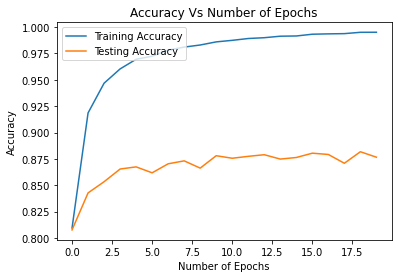

In [ ]:
import matplotlib.pyplot as plt

plt.plot(dest_object_name['accuracy'])
plt.plot(dest_object_name['val_accuracy'])
plt.title('Accuracy Vs Number of Epochs')
plt.ylabel('Accuracy')
plt.xlabel('Number of Epochs')
plt.legend(['Training Accuracy', 'Testing Accuracy'], loc='upper left')
plt.show()
# summarize history for loss


In [ ]:
import pickle

with open("/content/drive/My Drive/MSCI_641/fraud_1750.pkl", "rb") as f:
    dest_object_name = pickle.load(f)

In [ ]:
dest_object_name["accuracy"]

[0.8094333,
 0.9185944,
 0.9468102,
 0.9603578,
 0.96952295,
 0.97240454,
 0.9781878,
 0.9810694,
 0.9830505,
 0.98601216,
 0.987473,
 0.98921394,
 0.9899744,
 0.9913952,
 0.9916153,
 0.99327624,
 0.9936164,
 0.9938365,
 0.9950973,
 0.9951573]

In [ ]:
pred_1 = model.predict([X_test_head,X_test_body,X_test_head_tfidf,X_test_body_tfidf])
pred_old = np.argmax(pred_1,axis = 1)

In [ ]:
import sys
import numpy as np

def generate_features_new(stances,dataset,name):
    h, b, y = [],[],[]

    for stance in stances:
        y.append(LABELS.index(stance['Stance']))
        h.append(stance['Headline'])
        b.append(dataset.articles[stance['Body ID']])

    return y
  

competition_dataset = DataSet("competition_test")
y_competition = generate_features_new(competition_dataset.stances, competition_dataset, "competition")

Xs = dict()
ys = dict()

# Load/Precompute all features now
#Run on competition dataset
actual = [LABELS[int(a)] for a in y_competition]
predict_11= [LABELS[int(a)] for a in pred_old]
print(actual)
print(predict_11)

print("Scores on the test set")
report_score(actual,predict_11)

Reading dataset
Total stances: 25413
Total bodies: 904
['unrelated', 'unrelated', 'unrelated', 'unrelated', 'unrelated', 'unrelated', 'unrelated', 'unrelated', 'unrelated', 'unrelated', 'agree', 'unrelated', 'discuss', 'unrelated', 'discuss', 'agree', 'unrelated', 'unrelated', 'unrelated', 'unrelated', 'discuss', 'agree', 'agree', 'disagree', 'discuss', 'unrelated', 'unrelated', 'discuss', 'unrelated', 'agree', 'unrelated', 'unrelated', 'unrelated', 'unrelated', 'discuss', 'unrelated', 'unrelated', 'unrelated', 'unrelated', 'unrelated', 'unrelated', 'unrelated', 'unrelated', 'unrelated', 'unrelated', 'unrelated', 'unrelated', 'unrelated', 'discuss', 'unrelated', 'discuss', 'unrelated', 'unrelated', 'unrelated', 'unrelated', 'discuss', 'unrelated', 'discuss', 'unrelated', 'unrelated', 'unrelated', 'unrelated', 'discuss', 'unrelated', 'unrelated', 'unrelated', 'agree', 'unrelated', 'unrelated', 'unrelated', 'agree', 'unrelated', 'agree', 'unrelated', 'agree', 'unrelated', 'discuss', 'unr

80.68876729964596

In [ ]:
from sklearn.metrics import classification_report

print(classification_report(actual,predict_11))

              precision    recall  f1-score   support

       agree       0.56      0.59      0.58      1903
    disagree       0.44      0.44      0.44       697
     discuss       0.77      0.71      0.74      4464
   unrelated       0.95      0.96      0.96     18349

    accuracy                           0.88     25413
   macro avg       0.68      0.68      0.68     25413
weighted avg       0.88      0.88      0.88     25413



## EVALUATION

In [ ]:
from keras.models import load_model

xx= load_model("/content/drive/My Drive/MSCI_641/fraud_1750.hdf5")

pred = xx.predict([X_test_head,X_test_body,X_test_head_tfidf,X_test_body_tfidf])
pred_new = np.argmax(pred,axis = 1)

In [ ]:
import sys
import numpy as np

def generate_features_new(stances,dataset,name):
    h, b, y = [],[],[]

    for stance in stances:
        y.append(LABELS.index(stance['Stance']))
        h.append(stance['Headline'])
        b.append(dataset.articles[stance['Body ID']])

    return y
  

competition_dataset = DataSet("competition_test")
y_competition = generate_features_new(competition_dataset.stances, competition_dataset, "competition")

Xs = dict()
ys = dict()

# Load/Precompute all features now
#Run on competition dataset
actual = [LABELS[int(a)] for a in y_competition]
predict_1= [LABELS[int(a)] for a in pred_new]
print(actual)
print(predict_1)

print("Scores on the test set")
report_score(actual,predict_1)

Reading dataset
Total stances: 25413
Total bodies: 904
['unrelated', 'unrelated', 'unrelated', 'unrelated', 'unrelated', 'unrelated', 'unrelated', 'unrelated', 'unrelated', 'unrelated', 'agree', 'unrelated', 'discuss', 'unrelated', 'discuss', 'agree', 'unrelated', 'unrelated', 'unrelated', 'unrelated', 'discuss', 'agree', 'agree', 'disagree', 'discuss', 'unrelated', 'unrelated', 'discuss', 'unrelated', 'agree', 'unrelated', 'unrelated', 'unrelated', 'unrelated', 'discuss', 'unrelated', 'unrelated', 'unrelated', 'unrelated', 'unrelated', 'unrelated', 'unrelated', 'unrelated', 'unrelated', 'unrelated', 'unrelated', 'unrelated', 'unrelated', 'discuss', 'unrelated', 'discuss', 'unrelated', 'unrelated', 'unrelated', 'unrelated', 'discuss', 'unrelated', 'discuss', 'unrelated', 'unrelated', 'unrelated', 'unrelated', 'discuss', 'unrelated', 'unrelated', 'unrelated', 'agree', 'unrelated', 'unrelated', 'unrelated', 'agree', 'unrelated', 'agree', 'unrelated', 'agree', 'unrelated', 'discuss', 'unr

80.87758824160498

In [ ]:
from sklearn.metrics import classification_report

print(classification_report(actual,predict_1))

              precision    recall  f1-score   support

       agree       0.65      0.50      0.56      1903
    disagree       0.48      0.44      0.46       697
     discuss       0.76      0.76      0.76      4464
   unrelated       0.94      0.97      0.96     18349

    accuracy                           0.88     25413
   macro avg       0.71      0.67      0.68     25413
weighted avg       0.88      0.88      0.88     25413



In [ ]:
new_combine_df_test = combine_df_test

In [ ]:
new_combine_df_test.head()

,Headline,articleBody,Stances
0,Ferguson riots: Pregnant woman loses eye after...,A RESPECTED senior French police officer inves...,3
1,Crazy Conservatives Are Sure a Gitmo Detainee ...,Dave Morin's social networking company Path is...,3
2,A Russian Guy Says His Justin Bieber Ringtone ...,A bereaved Afghan mother took revenge on the T...,3
3,"Zombie Cat: Buried Kitty Believed Dead, Meows ...",Hewlett-Packard is officially splitting in two...,3
4,Argentina's President Adopts Boy to End Werewo...,An airline passenger headed to Dallas was remo...,3


In [ ]:
del new_combine_df_test["Stances"]

In [ ]:
new_combine_df_test.head()

,Headline,articleBody
0,Ferguson riots: Pregnant woman loses eye after...,A RESPECTED senior French police officer inves...
1,Crazy Conservatives Are Sure a Gitmo Detainee ...,Dave Morin's social networking company Path is...
2,A Russian Guy Says His Justin Bieber Ringtone ...,A bereaved Afghan mother took revenge on the T...
3,"Zombie Cat: Buried Kitty Believed Dead, Meows ...",Hewlett-Packard is officially splitting in two...
4,Argentina's President Adopts Boy to End Werewo...,An airline passenger headed to Dallas was remo...


In [ ]:
new_combine_df_test["Stance"] = predict_1

In [ ]:
new_combine_df_test.head()

,Headline,articleBody,Stance
0,Ferguson riots: Pregnant woman loses eye after...,A RESPECTED senior French police officer inves...,unrelated
1,Crazy Conservatives Are Sure a Gitmo Detainee ...,Dave Morin's social networking company Path is...,unrelated
2,A Russian Guy Says His Justin Bieber Ringtone ...,A bereaved Afghan mother took revenge on the T...,unrelated
3,"Zombie Cat: Buried Kitty Believed Dead, Meows ...",Hewlett-Packard is officially splitting in two...,unrelated
4,Argentina's President Adopts Boy to End Werewo...,An airline passenger headed to Dallas was remo...,unrelated


In [ ]:
new_combine_df_test.to_csv("/content/drive/My Drive/answers.csv",index=False,header=True,encoding='utf-8')